# Modeling

In this notebook, the performance of different models is examined.

## Setup

Import libraries.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Load datasets.

In [13]:
df_train = pd.read_csv("../data/processed/train.csv")
df_val = pd.read_csv("../data/processed/val.csv")
df_test = pd.read_csv("../data/processed/test.csv")

num_columns = df_val.shape[1]

print(f"The number of columns in the CSV file is: {num_columns}")

The number of columns in the CSV file is: 24


In [ ]:
X_train = df_train.drop(columns=["claim_number", "fraud"])
y_train = df_train["fraud"]
X_val = df_val.drop(columns=["fraud"])
y_val = df_val["fraud"]
X_test = df_test.drop(columns=["claim_number"])

## Model Selection

`OneHotEncoder` will dummify categorical features, and numerical features will be re-scaled with `MinMaxScaler`.

In [14]:


categorical_features = X_train.columns[X_train.dtypes == object].tolist()
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)
scaler = MinMaxScaler()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 21 but corresponding boolean dimension is 22

A simple function that defines the training pipeline: fit the model, predict on the validation set, print the evaluation metric.

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Assuming you have loaded your data into X_train, y_train, X_val, y_val
# ...

# Define categorical features
categorical_features = X_train.columns[X_train.dtypes == object].tolist()

# Set up a column transformer for preprocessing
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)

# Initialize a MinMaxScaler for scaling numerical features
scaler = MinMaxScaler()

# Create a machine learning pipeline
pipeline = make_pipeline(column_transformer, scaler)

# Fit and transform the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the validation data
X_val_transformed = pipeline.transform(X_val)


### K-Nearest Neighbor

KNN has two hyperparameters: the number of neighbors, and whether all points in each neighborhood are weighted equally or weighted by the inverse of their distance. Since the number of hyperparameters is small. A grid search is used to find the optimal hyperparameter values.

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

# Define your K-Nearest Neighbors Classifier
knnclf = KNeighborsClassifier()

# Define the column transformer and scaler
categorical_features = X_train.columns[X_train.dtypes == object].tolist()
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)
scaler = MinMaxScaler()

# Define the pipeline with SMOTE for handling class imbalance
pipeline_knn = make_imb_pipeline(
    column_transformer,
    scaler,
    SMOTE(random_state=42),  # Using SMOTE for oversampling
    knnclf
)

# Hyperparameter tuning using GridSearchCV for KNN
param_grid_knn = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7,10],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]
}

grid_search_knn = GridSearchCV(pipeline_knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

# Get the best KNN model from the grid search
best_model_knn = grid_search_knn.best_estimator_

# Make predictions on the validation set using KNN
y_val_pred_proba_knn = best_model_knn.predict_proba(X_val)[:, 1]
y_val_pred_knn = (y_val_pred_proba_knn > 0.5).astype(int)  # Adjust threshold if needed

# Evaluate the performance of KNN
accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
metric_knn = roc_auc_score(y_val, y_val_pred_proba_knn)
metric_f1_knn = f1_score(y_val, y_val_pred_knn)

# Print the results for KNN
print(f"Best params from GridSearchCV for KNN: {grid_search_knn.best_params_}")
print(f"Accuracy for KNN: {accuracy_knn}")
print(f"AUC score for KNN: {metric_knn}")
print(f"F1 score for KNN: {metric_f1_knn}")


Best params from GridSearchCV for KNN: {'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}
Accuracy for KNN: 0.5918310641844957
AUC score for KNN: 0.6111850639268711
F1 score for KNN: 0.29746532759445243


Confusion matrix of KNN

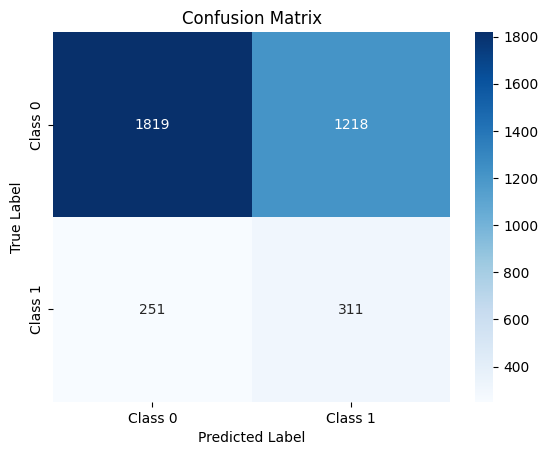

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns


predicted_labels = np.array(y_val_pred_knn)
true_labels = np.array(y_val)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1']


# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



### Logistic Regression with custom threshold

For logistic regression, there is no hyperparameter to tune.

In [9]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score
from sklearn.pipeline import make_pipeline

# loading datasets

df_train = pd.read_csv("../data/processed/train.csv")
df_val = pd.read_csv("../data/processed/val.csv")
df_test = pd.read_csv("../data/processed/test.csv")

# Split the data into features (X) and labels (y)
X_train = df_train.drop(columns=["claim_number", "fraud"])
y_train = df_train["fraud"]
X_val = df_val.drop(columns=["claim_number", "fraud"])
y_val = df_val["fraud"]

# Define categorical features
categorical_features = X_train.columns[X_train.dtypes == object].tolist()

# Set up a column transformer for preprocessing
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)

# Initialize a MinMaxScaler for scaling numerical features
scaler = MinMaxScaler()

# Create a machine learning pipeline
pipeline = make_pipeline(column_transformer, scaler)

# Fit and transform the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the validation data
X_val_transformed = pipeline.transform(X_val)

# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100,1000],
    'penalty': ['l2'],  # Use 'l2' penalty for lbfgs solver
}

# Create a logistic regression classifier
logreg_clf = LogisticRegression(solver='lbfgs', random_state=50)

# Create a GridSearchCV object
grid_search = GridSearchCV(
    logreg_clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
)

# Fit the model on the training data
grid_search.fit(X_train_transformed, y_train)

# Get the best model from the grid search
best_logreg_model1 = grid_search.best_estimator_

# Make predictions on the validation set with probabilities
val_probabilities = best_logreg_model1.predict_proba(X_val_transformed)[:, 1]
#val_probabilities = best_logreg_model.predict(X_val_transformed)
# Set a custom threshold (experiment with different values)
custom_threshold = 0.25

# Convert probabilities to binary predictions based on the custom threshold
val_predictions_custom_threshold = (val_probabilities > custom_threshold).astype(int)

# Calculate the confusion matrix and F1 score with the custom threshold
conf_matrix_custom_threshold = confusion_matrix(y_val, val_predictions_custom_threshold)
f1_custom_threshold = f1_score(y_val, val_predictions_custom_threshold)
accuracy = accuracy_score(y_val, val_predictions_custom_threshold)

print("Confusion Matrix with Custom Threshold:")
print(conf_matrix_custom_threshold)
print("F1 Score with Custom Threshold:", f1_custom_threshold)
print(accuracy)

Confusion Matrix with Custom Threshold:
[[2639  398]
 [ 364  198]]
F1 Score with Custom Threshold: 0.34196891191709844
0.7882745207001945


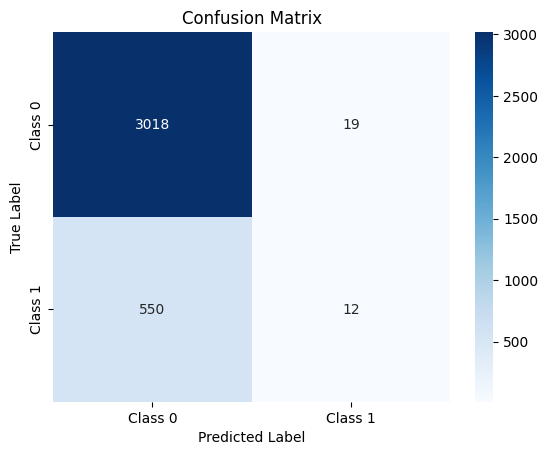

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

predicted_labels = np.array(val_predictions_custom_threshold)
true_labels = np.array(y_val)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1']


# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



###
Logistic regresion with majority minority weight sampling.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
import pandas as pd

# loading datasets

df_train = pd.read_csv("../data/processed/train.csv")
df_val = pd.read_csv("../data/processed/val.csv")
df_test = pd.read_csv("../data/processed/test.csv")

# Split the data into features (X) and labels (y)
X_train = df_train.drop(columns=["claim_number", "fraud"])
y_train = df_train["fraud"]
X_val = df_val.drop(columns=["claim_number", "fraud"])
y_val = df_val["fraud"]

# Define categorical features
categorical_features = X_train.columns[X_train.dtypes == object].tolist()

# Set up a column transformer for preprocessing
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)

# Initialize a MinMaxScaler for scaling numerical features
scaler = MinMaxScaler()

# Create a machine learning pipeline
pipeline = make_pipeline(column_transformer, scaler)

# Fit and transform the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Transform the validation data
X_val_transformed = pipeline.transform(X_val)

# Define the parameter grid for logistic regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    
}

# Define custom class weights
custom_class_weights = {0: 2.5, 1: 7.8}  # Adjust the weights as needed

# Create a logistic regression classifier with custom class weights
logreg_clf_custom_weights = LogisticRegression(solver='lbfgs', class_weight=custom_class_weights, random_state=42)

# Fit the model on the training data
logreg_clf_custom_weights.fit(X_train_transformed, y_train)

# Make predictions on the validation set
val_predictions_custom_weights = logreg_clf_custom_weights.predict(X_val_transformed)

# Calculate the confusion matrix, F1 score, and accuracy
conf_matrix_custom_weights = confusion_matrix(y_val, val_predictions_custom_weights)
f1_custom_weights = f1_score(y_val, val_predictions_custom_weights)
accuracy_custom_weights = accuracy_score(y_val, val_predictions_custom_weights)

print("Confusion Matrix with Custom Weights:")
print(conf_matrix_custom_weights)
print("F1 Score with Custom Weights:", f1_custom_weights)
print("Accuracy with Custom Weights:", accuracy_custom_weights)



Confusion Matrix with Custom Weights:
[[2605  432]
 [ 347  215]]
F1 Score with Custom Weights: 0.3556658395368073
Accuracy with Custom Weights: 0.783550986385107


### Confusion matrix of logistic regression with data sampling.


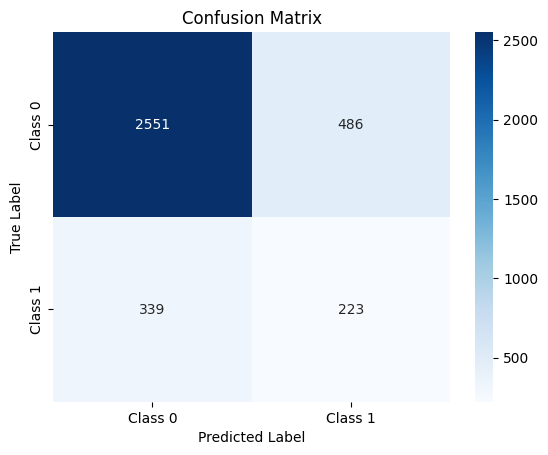

In [44]:
predicted_labels = np.array(val_predictions_custom_weights)
true_labels = np.array(y_val)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1']


# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



Look at the model coefficients.

In [ ]:
def add_dummies(df, categorical_features):
    dummies = pd.get_dummies(df[categorical_features], drop_first=True)
    df = pd.concat([dummies, df], axis=1)
    df = df.drop(categorical_features, axis=1)
    return df.columns

feature_names = add_dummies(X_train, categorical_features)

pd.DataFrame({
    "feature_name": feature_names,
    "coefficient": lr_pipeline._final_estimator.coef_[0]
}).sort_values(by="coefficient", ascending=False).reset_index(drop=True)

### XGBoost

Since there are many hyperparameters in XGBoost, I decide to use a randomized search for hyperparameter tuning.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline


# loading datasets

df_train = pd.read_csv("../data/processed/train.csv")
df_val = pd.read_csv("../data/processed/val.csv")
df_test = pd.read_csv("../data/processed/test.csv")

# Split the data into features (X) and labels (y)
X_train = df_train.drop(columns=["claim_number", "fraud"])
y_train = df_train["fraud"]
X_val = df_val.drop(columns=["claim_number", "fraud"])
y_val = df_val["fraud"]


# Define your XGBoost Classifier
xgbclf = XGBClassifier(random_state=42)

# Define the column transformer and scaler
categorical_features = X_train.columns[X_train.dtypes == object].tolist()
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)
scaler = MinMaxScaler()

# Define the pipeline with SMOTE for handling class imbalance
pipeline_xgb = make_imb_pipeline(
    column_transformer,
    scaler,
    SMOTE(random_state=42),  # Using SMOTE for oversampling
    xgbclf
)

# Hyperparameter tuning using GridSearchCV for XGBoost
param_grid_xgb = {
    'xgbclassifier__n_estimators': [50, 100, 200],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__subsample': [0.8, 1.0],
    'xgbclassifier__colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Get the best XGBoost model from the grid search
best_model_xgb = grid_search_xgb.best_estimator_

# Define your XGBoost Classifier
xgbclf = XGBClassifier(random_state=42)

# Fit the XGBoost model with your data
xgbclf.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred_proba = xgbclf.predict_proba(X_val)[:, 1]
threshold = 0.3  # Adjust the threshold based on experimentation
y_val_pred = (y_val_pred_proba > threshold).astype(int)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_val_pred)
metric = roc_auc_score(y_val, y_val_pred_proba)
metric_f1 = f1_score(y_val, y_val_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"AUC score: {metric}")
print(f"F1 score: {metric_f1}")


Confusion matrix of xgboost

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

predicted_labels = np.array(val_predictions_custom_weights)
true_labels = np.array(y_val)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1']


# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



### Random Forest

Here I implemented random forest with different n estimators and random state to see the difference in metrics.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import pandas as pd


#load dataset
df_train = pd.read_csv("../data/processed/train.csv")
df_val = pd.read_csv("../data/processed/val.csv")
df_test = pd.read_csv("../data/processed/test.csv")

# Split the data into features (X) and labels (y)
X_train = df_train.drop(columns=["claim_number", "fraud"])
y_train = df_train["fraud"]
X_val = df_val.drop(columns=["claim_number", "fraud"])
y_val = df_val["fraud"]


# Define your Random Forest Classifier
rfclf = RandomForestClassifier(random_state=42)

# Define the column transformer and scaler
categorical_features = X_train.columns[X_train.dtypes == object].tolist()
column_transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), categorical_features),
    remainder="passthrough",
)
scaler = MinMaxScaler()

# Define the pipeline with SMOTE for handling class imbalance
pipeline = make_imb_pipeline(
    column_transformer,
    scaler,
    SMOTE(random_state=42),  # Using SMOTE for oversampling
    rfclf
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'randomforestclassifier__n_estimators': [100],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba > 0.5).astype(int)  # Adjust threshold if needed

# Evaluate the performance
accuracy = accuracy_score(y_val, y_val_pred)
metric = roc_auc_score(y_val, y_val_pred_proba)
metric_f1 = f1_score(y_val, y_val_pred)

# Print the results
print(f"Best params from GridSearchCV: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"AUC score: {metric}")
print(f"F1 score: {metric_f1}")


### Confusion matrix of Random forest classifier


In [ ]:
predicted_labels = np.array(y_val_pred)
true_labels = np.array(y_val)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

class_labels = ['Class 0', 'Class 1']


# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()



To examine which feature is important, I introduce a feature with random numbers. A feature can be considered as important If the importance of that feature is larger than that of the random feature.

In [ ]:
X_train["random_feature"] = np.random.uniform(size=len(X_train))
xgb_clf_random_feature = XGBClassifier(**xgb_pipeline._final_estimator.best_params_)
steps = [column_transformer, scaler, xgb_clf_random_feature]
xgb_pipeline_random_feature = make_pipeline(*steps)
xgb_pipeline_random_feature = xgb_pipeline_random_feature.fit(X_train, y_train)

pd.DataFrame({
    "feature_name": list(feature_names) + ["random_feature"],
    "importance": xgb_pipeline_random_feature._final_estimator.feature_importances_
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

In [10]:
import pickle

with open('lgr_model.pickle','wb') as file:
    pickle.dump(best_logreg_model1,file)